# Project: Cardiovascular Disease: Causes, Treatment, and Prevention

In this project, I will investigate one of the the major causes of death in the world: cardiovascular disease!

In [60]:
# Run this cell to set up the notebook
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
np.set_printoptions(legacy='1.13')

import d8error

## Part 1: Causes of Death 

In order to get a better idea of how I can most effectively prevent deaths, I need to first figure out what the major causes of death are. Run the following cell to read in and view the causes_of_death table, which documents the death rate for major causes of deaths over the last century (1900 until 2015).
If you're interested, here is the original dataset! The age adjusted rate is the number of deaths per 100,000 population.

In [61]:
causes_of_death = Table.read_table('causes_of_death.csv')
causes_of_death.show(5)

Year,Cause,Age Adjusted Death Rate
2015,Heart Disease,168.5
2015,Cancer,158.5
2015,Stroke,37.6
2015,Accidents,43.2
2015,Influenza and Pneumonia,15.2


Each entry in the column **Age Adjusted Death Rate** is a death rate for a specific **Year** and **Cause** of death. 

If I look at unadjusted data, the age distributions of each sample will influence death rates. In an older population, I would expect death rates to be higher for all causes since old age is associated with higher risk of death. To compare death rates without worrying about differences in the demographics of our populations, I adjust the data for age.

The **Age Adjusted** specification in the death rate column tells me that the values shown are the death rates that would have existed if the population under study in a specific year had the same age distribution as the "standard" population, a baseline. 

You aren't responsible for knowing how to do this adjustment, but should understand why I adjust for age and what the consequences of working with unadjusted data would be.

These are all the different causes of death in this dataset. I assign `unique_causes` to an array of all the unique causes of death. 



In [62]:
unique_causes = np.unique(causes_of_death.column("Cause"))
sorted(unique_causes)

['Accidents', 'Cancer', 'Heart Disease', 'Influenza and Pneumonia', 'Stroke']

I would like to plot the death rate for each disease over time. To do so, I must create a table with one column for each cause and one row for each year.
I created a table called causes_for_plotting. It should have one column called Year, and then a column with age-adjusted death rates for each of the causes I found earloer. There should be as many of these columns in causes_for_plotting as there are causes in `unique_causes`.

In [63]:
def first(x):
    return x.item(0)

causes_for_plotting = causes_of_death.pivot("Cause", "Year" , "Age Adjusted Death Rate" , first)
causes_for_plotting.show(5)

Year,Accidents,Cancer,Heart Disease,Influenza and Pneumonia,Stroke
1900,90.3,114.8,265.4,297.5,244.2
1901,109.3,118.1,272.6,312.9,243.6
1902,93.6,119.7,285.2,219.3,237.8
1903,106.9,125.2,304.5,251.1,244.6
1904,112.8,127.9,331.5,291.2,255.2


Let's take a look at how age-adjusted death rates have changed across different causes over time. Run the cell below to compare Heart Disease (a chronic disease) and Influenza and Pneumonia (infectious diseases).

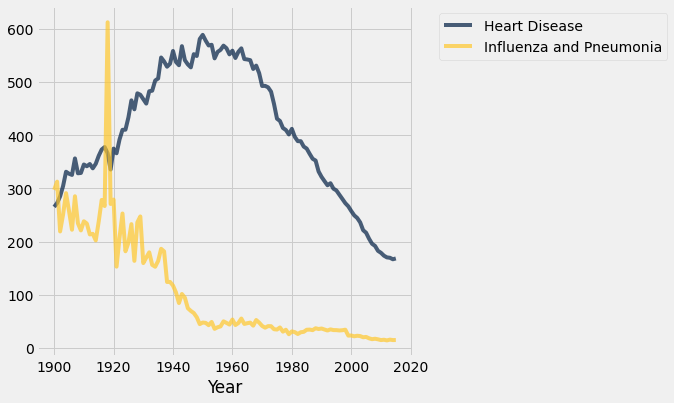

In [64]:
causes_for_plotting.select('Year', "Heart Disease", "Influenza and Pneumonia").plot('Year')

Beginning in 1900 and continuing until 1950, I observed that death rates for Influenza and Pneumonia decrease while death rates for Heart Disease increase. This phenomenon is known as the epidemiological transition: in developed countries, the severity of infectious disease has decreased, but chronic disease has become more widespread. Coronary heart disease (CHD) is one of the most deadly chronic diseases that has emerged in the past century, and more healthcare resources have been invested to studying it.

Run the cell below to see what a plot of the data would have looked like had you been living in 1950. CHD was the leading cause of death and had killed millions of people without warning. It had become twice as lethal in just a few decades and people didn't understand why this was happening.

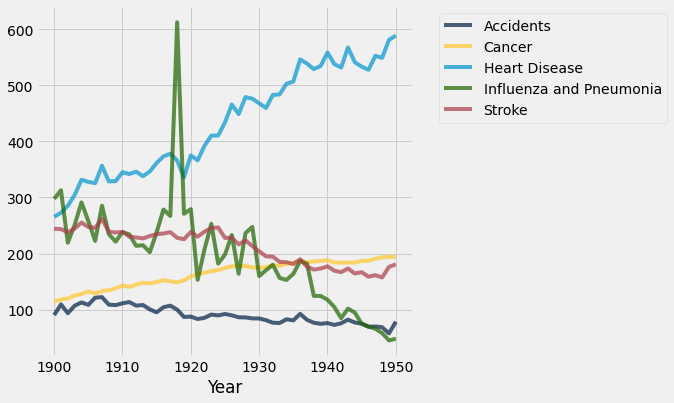

In [65]:

causes_for_plotting.where('Year', are.below_or_equal_to(1950)).plot('Year')

Let's examine the graph above. You'll see that in the 1960s, the death rate due to heart disease steadily declines. Up until then, the effects of smoking, blood pressure, and diet on the cardiovascular system were unknown to researchers. Once these factors started to be noticed, doctors were able recommend a lifestyle change for at-risk patients to prevent heart attacks and heart problems.

Note, however, that the death rate for heart disease is still higher than the death rates of most other causes. Even though the death rate is starkly decreasing, there's still a lot I don't understand about the causes (both direct and indirect) of heart disease.

## Part 2: The Framingham Heart Study

The [Framingham Heart Study](https://en.wikipedia.org/wiki/Framingham_Heart_Study) is an observational study of cardiovascular health. The initial study followed over 5,000 volunteers from  Framingham, Massachusetts for several decades, and followup studies even looked at their descendants. In this part of the project, I'll investigate some of the study's key findings about cholesterol and heart disease.

Run the cell below to examine data for 3,842 subjects from the first wave of the study, collected in 1956.

In [66]:
framingham = Table.read_table('framingham.csv')
framingham

AGE,SYSBP,DIABP,TOTCHOL,CURSMOKE,DIABETES,GLUCOSE,DEATH,ANYCHD
39,106,70,195,0,0,77,0,1
46,121,81,250,0,0,76,0,0
48,127.5,80,245,1,0,70,0,0
61,150,95,225,1,0,103,1,0
46,130,84,285,1,0,85,0,0
43,180,110,228,0,0,99,0,1
63,138,71,205,0,0,85,0,1
45,100,71,313,1,0,78,0,0
52,141.5,89,260,0,0,79,0,0
43,162,107,225,1,0,88,0,0


Each row contains data from one subject. The first seven columns describe the subject at the time of their initial medical exam at the start of the study. The last column, `ANYCHD`, tells me whether the subject developed some form of heart disease at any point after the start of the study; a value of 1 indicates that they **did** develop heart disease and a value of 0 indicates that they **did not** develop heart disease.

I noticed that the table contains fewer rows than subjects in the original study -- I am excluding subjects who already had heart disease or had missing data.

### Part 2, Section 1: Diabetes and the Population

Before I begin my investigation of cholesterol, I'll first look at some limitations of this dataset. In particular, I will investigate ways in which this is or isn't a representative sample of the population by examining the number of subjects with diabetes.

[According to the CDC](https://www.cdc.gov/diabetes/statistics/slides/long_term_trends.pdf), the **prevalence of diagnosed diabetes (i.e., the proportion of the population who have it) in the U.S. around this time was 0.0093.** I am going to conduct a hypothesis test with the following null and alternative hypotheses:

**Null Hypothesis**: The probability that a participant within the Framingham Study has diabetes is *equivalent* to the prevalence of diagnosed diabetes within the population. (i.e., any difference is due to chance).

**Alternative Hypothesis**: The probability that a participant within the Framingham Study has diabetes is *different* from the prevalence of diagnosed diabetes within the population.

I am going to use the absolute distance between the **observed prevalence** in the study and the **true population prevalence** as our test statistic. The column `DIABETES` in the `framingham` table contains a 1 for subjects with diabetes and a `0` for those without.

I assigned `observed_diabetes_distance` to the observed value of the test statistic in the data from the Framingham Study 

I also took in mind that I need to perform my calculations based on the 3,842 subjects in the `framingham` table, not the 5,000 original study participants. Also, that prevalence is defined as the proportion of the population who have a disease.

In [67]:
true_population_prevalence = np.sum(framingham.group("DIABETES")[1][1])/len(framingham.column("DIABETES"))
observed_diabetes_distance = np.abs(true_population_prevalence - 0.0093)
observed_diabetes_distance

0.018029515877147319

I defined the function `diabetes_test_statistic` which should return exactly one simulated statistic of the absolute distance between the observed prevalence and the true population prevalence under the null hypothesis. I made sure that my simulated sample is the same size as my original sample.

I also created an array `diabetes_proportions` contains the proportions of the population without and with diabetes, respectively.

In [68]:
diabetes_proportions = make_array(.9907, .0093)
def diabetes_test_statistic():
    one_sample_proportion = sample_proportions(5000, diabetes_proportions)
    return np.abs(one_sample_proportion.item(1) - diabetes_proportions.item(1))
diabetes_test_statistic()

0.0010999999999999985

I completed the following code to simulate 5,000 values of the statistic under the null hypothesis.

In [69]:
diabetes_simulated_stats = make_array()

for i in np.arange(5000): 
    new_simulation = diabetes_test_statistic()
    diabetes_simulated_stats = np.append(diabetes_simulated_stats, new_simulation)
    
diabetes_simulated_stats

array([ 0.0021,  0.0015,  0.0003, ...,  0.0011,  0.0009,  0.0009])

I ran the following cell to generate a histogram of the simulated values of your statistic, along with the observed value.

/Users/elle/Library/Python/3.8/lib/python/site-packages/datascience/tables.py:5206: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(ticks, rotation='vertical')


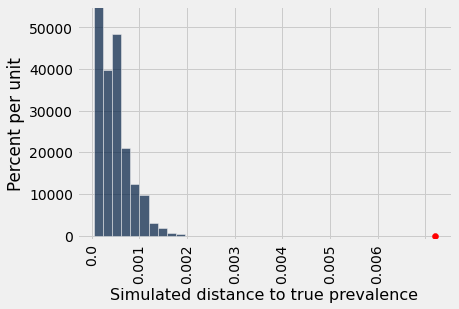

In [70]:
Table().with_column('Simulated distance to true prevalence', diabetes_simulated_stats).hist()
plots.scatter(observed_diabetes_distance, 0, color='red')
plots.ylim(-10, 550);

As I can see that our `observed_diabetes_distance` is very far right from our distribution. This suggest that the observed value of the statistic and the predicted behavior of the statistic under the null hypothesis are inconsistent. 

The conclusion of the test is that the data favor the alternative over the null. It supports the hypothesis that the probability that a participant within the Framingham Study has diabetes is different from the prevalence of diagnosed diabetes within the population.

I infered these statement from looking at the trend observed and my hypothesis test results:

1. Diabetes was under-diagnosed in the population (i.e., there were a lot of people in the population who had diabetes but weren't diagnosed). By contrast, the Framingham participants were less likely to go undiagnosed because they had regular medical examinations as part of the study.
2. The Framingham Study subjects were older on average than the general population, and therefore more likely to have diabetes.



In real-world studies, getting a truly representative random sample of the population is often incredibly difficult. Even just to accurately represent all Americans, a truly random sample would need to examine people across geographical, socioeconomic, community, and class lines (just to name a few). For a study like this, scientists would also need to make sure the medical exams were standardized and consistent across the different people being examined. In other words, there's a tradeoff between taking a more representative random sample and the cost of collecting more information from each person in the sample.

The Framingham study collected high-quality medical data from its subjects, even if the subjects may not be a perfect representation of the population of all Americans. This is a common issue that data scientists face: while the available data aren't perfect, they're the best I have. The Framingham study is generally considered the best in its class, so I'll continue working with it while keeping its limitations in mind.

(For more on representation in medical study samples, you can read these articles from [NPR](https://www.npr.org/sections/health-shots/2015/12/16/459666750/clinical-trials-still-dont-reflect-the-diversity-of-america) and [Scientific American](https://www.scientificamerican.com/article/clinical-trials-have-far-too-little-racial-and-ethnic-diversity/)).

### Part 2, Section 2: Cholesterol and Heart Disease

In the remainder of this part, I am going to examine one of the main findings of the Framingham study: an association between serum cholesterol (i.e., how much cholesterol is in someone's blood) and whether or not that person develops heart disease.

I'll use the following null and alternative hypotheses:

**Null Hypothesis:** In the population, the distribution of cholesterol levels among those who develop heart disease is the *same* as the distribution of cholesterol levels among those who do not.

**Alternative Hypothesis:** The cholesterol levels of people in the population who develop heart disease are *higher*, on average, than the cholesterol level of people who do not.

From the provided null and alternative hypotheses, it seem reasonable to use A/B Testing to determine which model is more consistent with our data. The reason for this is that I am deciding whether two numerical samples come from the same underlying distribution.

Now that I have a null hypothesis, I need to formulate a test statistic. A factor to consider is that larger values of the test statistic should favor the alternative over the null. 

**Test Statistic:**  The difference between the average cholesterol levels of those who get heart disease and those who don't

I choice this test statistic because the alternative hypothesis compares the average cholesterol level two groups and says that the average for those who develop heart disease are *higher*. Therefore it is reasonable for me to use the difference between the two group means as our test statistic. 

I wrote a function that computes my test statistic. It should take a table that has the following two columns, `TOTCHOL` (total serum cholesterol) and `ANYCHD` (whether or not the person had coronary heart disease), and compute the test statistic I described above. Note that the table can have more than just the two columns listed above.

I also used this function to compute the observed test statistic, and assigned it to the name `framingham_observed_statistic`.

In [71]:
def framingham_test_statistic(tbl):
    yes_heart = np.mean(tbl.select('TOTCHOL', 'ANYCHD').where('ANYCHD', are.equal_to(1)).column('TOTCHOL'))
    no_heart = np.mean(tbl.select('TOTCHOL', 'ANYCHD').where('ANYCHD', are.equal_to(0)).column('TOTCHOL'))
    return yes_heart - no_heart 
framingham_observed_statistic = framingham_test_statistic(framingham)
framingham_observed_statistic

16.635919905689406

Now that I have defined hypotheses and a test statistic, I am ready to conduct a hypothesis test. I'll start by defining a function to simulate the test statistic under the null hypothesis, and then use that function 500 times to understand the distribution under the null hypothesis.

The `simulate_framingham_null` function should simulate the null hypothesis once (not 500 times) and return the value of the test statistic for that simulated sample.

In [72]:
def simulate_framingham_null():
     # array of shuffled labels
    shuffled_labels = framingham.sample(with_replacement=True).column('ANYCHD')
    resample = framingham.with_column("ANYCHD", shuffled_labels)
    
    return framingham_test_statistic(resample)
    
simulate_framingham_null()

0.80360591923451352

I also completed the simulation for the hypothesis test. My simulation should compute 500 values of the test statistic under the null hypothesis and store the result in the array `framingham_simulated_stats`.

In [73]:
framingham_simulated_stats = make_array()

for i in np.arange(500):
    new_simulation = simulate_framingham_null()
    framingham_simulated_stats = np.append(framingham_simulated_stats, new_simulation)

The following line will plot the histogram of the simulated test statistics, as well as a point for the observed test statistic. 

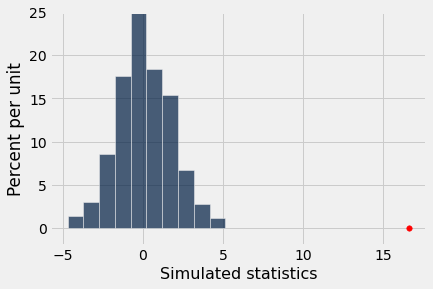

In [74]:
Table().with_column('Simulated statistics', framingham_simulated_stats).hist()
plots.scatter(framingham_observed_statistic, 0, color='red', s=30)
plots.ylim(-0.02, 0.25);

I computed for the p-value for this hypothesis test, and assigned it to the name `framingham_p_val`.

One of the key findings of the Framingham study was a strong association between cholesterol levels and heart disease. My p-value should match up with this finding.

In [75]:
framingham_p_val = np.count_nonzero(framingham_simulated_stats >= framingham_observed_statistic) / 100 
framingham_p_val

0.0

Despite the Framingham Heart Study's well-deserved reputation as a well-conducted and rigorous study, it has some major limitations. A specific reason why it can't be said that high cholesterol *causes* heart disease is that A/B testing does not give causation, but only correlation. I cannot link *causation* between high cholesterol and heart disease without treatment/control groups. I can only infer *correlation* rather than causation. Often times in observational studies, I can not indicate causation and not the correlation between two samples.

Similar studies from the 1950s found positive associations between diets high in saturated fat, high cholesterol, and incidence of heart disease. In 1962, the U.S. Surgeon General said:

> "Although there is evidence that diet and dietary habits may be implicated in the development of coronary heart disease and may be significant in its prevention or control, at present our only research evidence is associative and not conclusive."

## Part 3: Hormone Replacement Therapy for Cardiovascular Health

### The Nurses' Health Study
The Nurses' Health Study (NHS) is another very large observational study which has brought many insights into women's health. It began in 1976, by Dr. Frank Speizer, with questionnaires that were mailed to 121,964 female registered nurses in the United States asking about their medical history, cholesterol and blood pressure, current medications, and so on (one of the benefits of studying nurses is their ability to give reliably accurate answers to these questions). 

The study's initial focus was on investigating the long-term health effects of oral contraceptives, whose use had become much more widespread in the U.S. during the 1960s, but the focus soon expanded to investigating a wide variety of questions on women's health. The NHS is still ongoing, and is now tracking its third generation of nurses in the US.

**One of the most consequential early findings from the NHS was about hormone replacement therapy (HRT)**: supplementary estrogen and progesterone for post-menopausal women to relieve side effects of declining hormone levels due to menopause. The NHS found that HRT in post-menopausal women was negatively associated with heart attack risk. In other words, higher levels of HRT in post-menopausal women were associated with lower risk of heart attack. In a landmark 1985 paper in the *New England Journal of Medicine* (NEJM), Speizer and his coauthors wrote that **women on HRT are half as likely to suffer a heart attack over a certain time period.** [(Stampfer et al., 1985)](https://www.ncbi.nlm.nih.gov/pubmed/4047106) We'll define the term "relative risk" later in this section, and we'll also investigate the interpretation of these claims and their statistical basis.

Based on the passage above, I can infer the following about the Nurses' Health Study: 

1. Since only nurses were included in the study, there's a chance that confounding factors influence our dataset.
2. The study uses data that was self-reported by nurses for the analysis.

**The scientists running the NHS wanted to compare post-menopausal women who had taken HRT with post-menopausal women who had never taken HRT, excluding all women who were not post-menopausal or who had previously suffered a heart attack.** This study design complicates the analysis because it creates a variety of reasons why women might drop in and out of the relevant comparison groups. They sent out surveys in 1976, 1978, and 1980, so they could receive information at different timestamps and thus participants might "change groups" midway through. 

If you're interested, read more about the study [here](https://pubmed.ncbi.nlm.nih.gov/4047106/).

Because women could (and did) drop into and out of the comparison groups in the middle of the study, it is difficult to make a table like I usually would, with one row per participant. In medical studies, individuals are typically weighted by the *amount of time* that they enrolled in the study. A more convenient sampling unit is a **person-month at risk**, which is one month spent by a particular woman in one of the comparison groups, during which she might or might not suffer a heart attack. Here, "at risk" just means the woman is being tracked by the survey in either of the two comparison groups, so that if she had a heart attack it would be counted in our data set.

**Example**: The table below tracks the histories of two hypothetical post-menopausal women in a six-month longitudinal study, who both enter the study in January 1978:
1. Alice has never been on HRT. She has a heart attack in March and is excluded for the remainder of the study period. 
2. Beatrice begins taking HRT for the first time in April and stays healthy throughout the study period.

| Name     | Month    | HRT | Heart Attack   |                                             
|----------|----------|-----|----------------|
| Alice    | Jan 1978 |  0  | 0              |
| Alice    | Feb 1978 |  0  | 0              |
| Alice    | Mar 1978 |  0  | 1              |
| Beatrice | Jan 1978 |  0  | 0              | 
| Beatrice | Feb 1978 |  0  | 0              |
| Beatrice | Mar 1978 |  0  | 0              |
| Beatrice | Apr 1978 |  1  | 0              |
| Beatrice | May 1978 |  1  | 0              |
| Beatrice | Jun 1978 |  1  | 0              |




Incidence refers to the proportion of persons who develop a condition during a particular time period. Since I want to examine the risk of developing a heart attack, I can define the **incidence rate of a heart attack** as the probability that a heart attack will happen to a given at-risk person in a given time period. The NHS calculated its effects in terms of the **relative risk**, which is simply the incidence rate for *person-months* in the HRT (Group A) group divided by the incidence rate in the no-HRT (Group B) group.

$$\text{Relative Risk} = \frac{\text{Incidence Rate(Treatment Group)}}{\text{Incidence Rate(Control Group)}}$$

If the incidence rate of the treatment group is greater than the incidence rate of the control group, the relative risk will be **greater than**. This means that individuals in the treatment group are at **higher** risk of having a heart attack compared to those in the control group.

If the incidence rate of the treatment group is less than the incidence rate of the control group, the relative risk will be **less than**. This means that individuals in the treatment group are at **lower** risk of having a heart attack compared to those in the control group.

If the incidence rate of the treatment group is equal to the incidence rate of the control group, the relative risk will be **equal to**. This means that individuals in the treatment group are at **equal** risk of having a heart attack compared to those in the control group.

Most statistical methods that deal with this type of data assume that I can treat a table like the one above as though it is a sample of independent random draws from a much larger population of person-months at risk in each group. **I will take this assumption for granted throughout the rest of this section.**

Instead of *person-months* at risk, the NHS used *person-years* at risk. It reported 51,478 total person-years at risk in the no-HRT group with 60 heart attacks occurring in total, as well as 54,309 person-years at risk in the HRT group with 30 heart attacks occurring in total. The table NHS below has one row for each person-year at risk. The two columns are 'HRT', recording whether it came from the HRT group (1) or no-HRT group (0), and 'Heart Attack', recording whether the participant had a heart attack that year (1 for yes, 0 for no).

In [76]:
NHS = Table.read_table('NHS.csv')
NHS.show(5)

HRT,Heart Attack
0,0
0,0
0,0
0,0
0,0


Using the NHS data, I can now conduct a hypothesis test to investigate the relationship between HRT and risk of CHD. As a reminder, the **incidence rate** is defined as the proportion of people who died in a specific group out of the total number who participated in the study from that group.

I'll use the following null and alternative hypotheses and test statistic:

**Null Hypothesis:** HRT *does not* affect the risk of CHD, and the true relative risk is equal to 1. Any deviation is due to random chance.

**Alternative Hypothesis:** HRT *decreases* the risk of CHD, and the true relative risk is less than 1.

**Test Statistic:** Relative risk of CHD between post-menopausal women receiving HRT and post-menopausal women not receiving HRT (the definition of relative risk is repeated here for your convenience):

$$\text{Relative Risk} = \frac{\text{Incidence Rate(Treatment Group)}}{\text{Incidence Rate(Control Group)}}$$

**Note:** Remember that I assume, under the null, that the two populations are derived from the same much larger population—under this assumption $\text{Incidence Rate(Treatment Group)} = \text{Incidence Rate(Control Group)}$. After simulation, I test this hypothesis by viewing the `relative_risk` for our simulated samples.

I wrote a function called `relative_risk` that takes in a table with the column labels `HRT` and `Heart Attack`, and computes the sample relative risk as an estimate of the population relative risk. I did *not* round my answer.

In [77]:
def relative_risk(tbl):
    """Return the ratio of the incidence rates (events per person-year) for the two groups"""
    incidence_treatment = np.average(tbl.where("HRT", are.equal_to(1)).column("Heart Attack"))
    incidence_control = np.average(tbl.where("HRT", are.equal_to(0)).column("Heart Attack"))
    return incidence_treatment/incidence_control
relative_risk(NHS)

0.47393618000699694

I wrote the function `one_bootstrap_rr` so that it **generates one bootstrap sample and computes the relative risk**. I also assigned `bootstrap_rrs` to 15 estimates of the population relative risk.

*Note:* I am only doing 15 estimates because the code is slow! The cell may take a few seconds to run.

In [78]:
def one_bootstrap_rr():
    return relative_risk(NHS.sample())

bootstrap_rrs = make_array()
for i in np.arange(15):
    new_bootstrap_rr = one_bootstrap_rr()
    bootstrap_rrs = np.append(bootstrap_rrs, new_bootstrap_rr)
  

The file `bootstrap_rrs.csv` contains a one-column table with 2001 saved bootstrapped relative risks. I used these bootstrapped values to compute a 95% confidence interval, storing the left endpoint as `ci_left` and the right endpoint as `ci_right`. 

Note that my method isn't exactly the same as the method employed by the study authors to get their confidence interval.

In [79]:
bootstrap_rrs_from_tbl = Table.read_table('bootstrap_rrs.csv').column(0)
ci_left = percentile(2.5, bootstrap_rrs_from_tbl)
ci_right = percentile(97.5, bootstrap_rrs_from_tbl)

print("Middle 95% of bootstrappped relative risks: [{:f}, {:f}]".format(ci_left, ci_right))

Middle 95% of bootstrappped relative risks: [0.295930, 0.730383]


The code below plots the confidence interval on top of the bootstrap histogram.

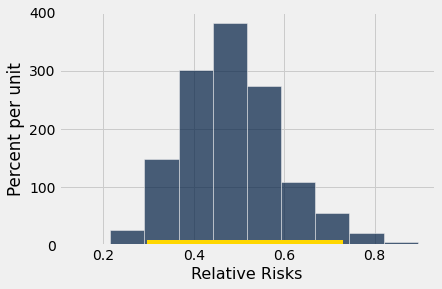

In [80]:
Table().with_column("Relative Risks", bootstrap_rrs_from_tbl).hist()
plots.plot([ci_left, ci_right], [.05,.05], color="gold");

The following text is an excerpt from the abstract of the original 1985 paper. 
> As compared with the risk in women who had never used postmenopausal hormones, the age-adjusted relative risk of coronary disease in those who had ever used them was 0.5 (95 per cent confidence limits, 0.3 and 0.8; P = 0.007)... These data support the hypothesis that the postmenopausal use of estrogen reduces the risk of severe coronary heart disease. [(Stampfer et al., 1985)](https://www.ncbi.nlm.nih.gov/pubmed/4047106)

The authors give a 95% confidence interval of [0.3, 0.8] for the relative risk. The following statements can be justified based on that confidence interval:

1. If I used a P-value cutoff of 5%, I would reject the null hypothesis that HRT does not affect the risk of CHD.
2. If I redo the procedure that generated the interval [0.3, 0.8] on a fresh sample of the same size, there is a 95% chance it will include the true relative risk.


My conclusion from this test was that hormone replacement therapy associated with a decreased risk of heart attacks. To explain this further, I refered back to the definition and interpretations of relative risk.

As you can see that the middle 95% confidence interval is around [0.295930, 0.730383], meaning I have a lower relative risk.
Thus, this lower relative risk mean we have a lower incidence rate of the treatment group than the incidence rate of the control group. Futhermore, this means that the individuals in the treatment group are at less than risk of having heart attack compared to those in the control group.

Partly as a result of evidence from the NHS and other observational studies that drew similar conclusions, HRT drugs became a very popular preventive treatment for doctors to prescribe to post-menopausal woman. Even though there were known or suspected risks to the treatment (such as increasing the risk of invasive breast cancer), it was thought that the reduction in heart disease risk was well worth it.

However, a later study, the [Heart and Estrogen-Progestin Replacement Study](https://jamanetwork.com/journals/jama/fullarticle/187879), found that HRT did **not** have a significant impact on a woman's risk of CHD. These findings contradicted the results of the Nurses' Heart study, challenging the efficacy of a treatment that had become the standard of care for heart disease prevention. The HERS study authors put forward a possible answer regarding why the NHS study might be biased:
> The observed association between estrogen therapy and reduced CHD risk might be attributable to selection bias if women who choose to take hormones are healthier and have a more favorable CHD profile than those who do not. Observational studies cannot resolve this uncertainty.

**Selection bias** occurs in observational studies when there is a systematic difference between participants that receive a treatment and participants that do not receive a treatment. When this type of bias is present, the observed treatment effect might be a result of an unmeasured confounding variable.

Futhermore, if women who choose to take hormones are healthier to begin with than women who choose not to, this might systematically bias the results of observational studies like the NHS. I would expect that the observational studies overestimated the protective effect of HRT.



### Further reading

If you're interested in learning more, you can check out these articles:

* [Origin story of the Framingham Heart Study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1449227/)
* [NYT article on the Nurses' Health Study and the HERS study](https://www.nytimes.com/2003/04/22/science/hormone-studies-what-went-wrong.html)

## Part 4: Diet and Cardiovascular Disease

To establish a causal link between saturated fat intake, serum cholesterol, and heart disease, a group of doctors
in the US established the National Heart-Diet Study. The study was based in 6 centers: Baltimore, Boston, Chicago, Minneapolis-St. Paul, Oakland, and Faribault, MN. The first 5 centers recruited volunteers from the local population: volunteers and their families were asked to adjust their diet to include more or less saturated fat.

The sixth center was organized by Dr. Ivan Frantz, and its study was known as the Minnesota Coronary
Experiment.  The main difference between the Minnesota Coronary Experiment and the rest of the National Diet-Heart Study was
the setting. While the other centers in the study looked at volunteers, Dr. Frantz conducted his study at Faribault
State Hospital, which housed patients who were institutionalized due to disabilities or mental illness.

Although standards for informed consent in participation weren't as strict then as they are today, the study was
described as follows:

>No consent forms were required because the study diets were considered to be acceptable as house diets and
the testing was considered to contribute to better patient care. Prior to beginning the diet phase, the project was
explained and sample foods were served. Residents were given the opportunity to decline participation.

Despite the level of detail and effort in the study, the results of the study were never extensively examined until
the early 21st century. Over 40 years after the data were collected, Dr. Christopher Ramsden heard about the
experiment and asked Dr. Frantz's son, Robert, to uncover the files in the Frantz family home's dusty basement.
You can learn more about the story of how the data was recovered on the [Revisionist History podcast](http://revisionisthistory.com/episodes/20-the-basement-tapes) or in [Scientific American magazine](https://www.scientificamerican.com/article/records-found-in-dusty-basement-undermine-decades-of-dietary-advice/).

In recent years, poor treatment of patients at Faribault State Hospital (and other similar institutions in Minnesota)
has come to light: the state has recently changed patients' gravestones from numbers to their [actual names](https://www.tcdailyplanet.net/minnesota-saying-sorry-treatment-persons-disabilities/), and apologized for [inhumane treatment of patients](https://www.tcdailyplanet.net/minnesota-saying-sorry-treatment-persons-disabilities/).

While the data from such a study may be useful scientifically, it also raises major ethical concerns.

Since most patients are suffering from mental illnesses and disability, they don't have the independence and the right mindset to give best decisions for themselves, thus giving more authority for the people conducting the study to do more unethical medical procedures/decisions that could be not the best/appropiate for the patient. 

### The Data

The National Heart-Diet Study was very relevant for analysis on the relationship between saturated fats and heart disease. However, an important part of medical studies is *replication*, or being able to see the same results in multiple studies.

Suppose that 50 scientists decide to independently recreate the NHDS study. Each of these fictional researchers studied 100 people and collected data on whether their diet was **high** or **low** in saturated fats. To imitate the original experiment, the researchers followed up 5 years later and recorded whether each participant was alive or dead at that time. Note that this fictional study is unlike Dr. Frantz's experiment in that this scenario is observing whether the participants' diets were high or low in saturated fats. The participants are not assigned to a certain group. 

I will assume that all 50 scientists sampled from the same population, described in full below. Note that *normally* I would never have access to this information - I'd only know the data in our sample. The table `population` has a row for each person in the population, and the following three attributes:
- **Age**: a string, the age group of the person
- **Diet**: a string, "low" or "high" describing the amount of saturated fats in the person's diet
- **Died**: a boolean, describing whether or not the person had died within the 5 years

Run the cell below to see what the population looked like.

In [81]:
population = Table.read_table('population.csv').drop(0)
population.show(5)
population.group("Age")

Age,Diet,Died
0-34,Low,True
0-34,Low,True
0-34,Low,True
0-34,Low,False
0-34,Low,False


Age,count
0-34,2704
35-44,1459
45-54,1583
55-64,1766
65+,1911


### Running a Hypothesis Test
I have been tasked with helping these scientists explore how different diets are associated with death rates. Since the samples were taken at random, the 50 scientists may have reached different conclusions, even if they do the same hypothesis test.

I set up a null hypothesis and an alternative hypothesis that I can use to answer whether or not the amount of saturated fat in ones diet is associated with different rates of death in the two groups. I am interested in observing *any* change, not specifically an increase or decrease in death rates.

**Null Hypothesis**: The death rates of the "Low" and "High" (saturated fat groups) will be the same regardless of the amount of saturated fat in their diets, and any deviation is due to random chance.<br><br>
**Alternative Hypothesis**:The death rate of the two groups is different and statistically significant.

In thinking of a test statistic, one researcher decides that the absolute difference in the number of people who died in each group is a valid test statistic. The  specific reason why this test statistic will not work is because I want to examine the risk of developing a heart disease, using absolute difference is not appropiate because the number of people in each group might be different from each other. Example the saturated fat group has only 10 people but all of them died, while the other group has 50 and 30 of them died, it makes it seem like the normal diet is associated with more deaths, so I may be misrepresenting the data by just using pure head count. Thus using ratios is more appropiate.

To combat the problem above, I instead decide to use the the absolute difference in incidence rates between the two groups as our test statistic. Here, the incidence rate of death is defined as **the proportion of people who *died* in a specific group out of the total number who participated in the study from that group.**

The researchers have provided two functions that may help me. These are similar to functions you have defined earlier to perform hypothesis tests.

In [82]:
def compute_incidence_statistic(data_tbl):
    """"Given a sample from population, returns the test statistic"""
    summed_tbl = data_tbl.with_column("Total", 1).drop('Age').group('Diet', sum)
    incidence_rate = summed_tbl.column("Died sum") / summed_tbl.column("Total sum")
    return abs(incidence_rate.item(0) - incidence_rate.item(1))

def simulate_death_null(tbl):
    """Simulates a single value of the test statistic under the null hypothesis."""
    shuffled_death = tbl.select('Died').sample(with_replacement=False).column(0)
    return compute_incidence_statistic(tbl.with_column('Died', shuffled_death))

I am now in a position to run a hypothesis test to help differentiate between my two hypotheses using any set of sample data. I defined a function `complete_test` which takes in `tbl`, a single sample from the population. It should shuffle labels and calculate the incidence rate difference for the sample under the null hypothesis 100 times, and use these simulated values to return a p-value with respect to the observed data.

I used the two functions defined above `compute_incidence_statistic` and `simulate_death_null`, in creating this `complete_test` function

In [83]:
def complete_test(tbl):
    observed_stat= compute_incidence_statistic(tbl)
    
    simulated_stats = make_array()
    for i in np.arange(100):
        new_stat = simulate_death_null(tbl)
        simulated_stats  = np.append(simulated_stats, new_stat)
    
    return np.count_nonzero(simulated_stats >= observed_stat) / 100

Using the function I just defined, I simulated taking 50 different samples of size 100 without replacement from the `population` table, and **run a hypothesis test on each of them**. (Note that I am are running 50 hypothesis tests, rather than computing 50 test statistics). I stored the resulting p-values in an array called `results`.

In [84]:
repetitions = 50
results = make_array()
for i in range(repetitions):
    new_results = population.sample(100, with_replacement=False)
    results = np.append(results, complete_test(new_results))

For each test, can its scientist conclude that the amount of fat in ones diet is associated with a changed death rate? Suppose I decide to use a p-value cutoff of 0.05. 

I assigned `rejected_null` to an array whose entries are either `True` or `False` depending on whether the corresponding test rejected the null or failed to reject the null, respectively. For example, if the 0th test failed to reject the null, the 0th item in the array should be `False`. 

In [85]:
rejected_null = results >= 0.05
rejected_null

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

Suppose I now find out that the null hypothesis is actually true -- in the population, there is no significant difference in death rates based on saturated fat consumption. 

I assigned the proportion of the conclusions that were incorrect (i.e. they wrongly rejected the null) to `actual_prop_wrong` and the eproportion of the conclusions that I *expected* to be incorrect to `expected_prop_wrong`.

In [86]:
actual_prop_wrong = np.average(rejected_null == False)
expected_prop_wrong = 0.05
actual_prop_wrong, expected_prop_wrong

(0.02, 0.05)